In [1]:
from disentanglement.data.UTKFace import get_dataset, get_dataset_filepaths, get_process_path_function, get_label



In [2]:
filepaths = get_dataset_filepaths("../datasets/UTKFace/")

In [3]:
len(filepaths)

23708

In [4]:
from sklearn.model_selection import train_test_split

train_filepaths, test_filepaths = train_test_split(
        filepaths,
        test_size=0.0,
        random_state=0,
        shuffle=True)

train_dataset = get_dataset("utkface", filepaths=train_filepaths).take(-1)
test_dataset = get_dataset("utkface", filepaths=test_filepaths).take(-1)

2024-12-11 11:16:40.161050: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-11 11:16:40.161076: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-11 11:16:40.161082: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-11 11:16:40.161114: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 11:16:40.161130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
len(train_filepaths)

In [6]:
process_func = get_process_path_function(get_label, target_size=(128, 128))

In [7]:
import numpy as np
X_train = []
y_train = []
for img, label in [process_func(train_filepaths[i]) for i in range(len(train_filepaths))]:
    X_train.append(img)
    y_train.append(label)

X_train = np.array(X_train) /255
y_train = np.array(y_train) 

In [8]:
X_test = []
y_test = []
for img, label in [process_func(test_filepaths[i]) for i in range(len(test_filepaths))]:
    X_test.append(img)
    y_test.append(label)

X_test = np.array(X_test) / 255
y_test = np.array(y_test) 

In [15]:
from keras.src.layers import Dense, Input, Conv2D, Dropout, GlobalAveragePooling2D, MaxPooling2D, Flatten
from keras import Model

from disentanglement.models.architectures import get_cifar10_convolutional_blocks
import keras
import tensorflow as tf
# model = get_cifar10_convolutional_blocks(input_shape=(200,200,3))
# model.add(Dense(32))

model = keras.Sequential(
    [Input((128, 128, 3)),
    Conv2D(64, (2, 2), activation="relu", padding="same"),
    Conv2D(128, (2, 2), activation="relu", padding="same"),
    Conv2D(256, (2, 2), activation="relu", padding="same"),
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.25),]
)
model.add(Dense(1))

inputs = Input((128, 128, 3))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)

output = Dense(1, activation='relu', name='age_out') (dropout_1)
model = Model(inputs=[inputs], outputs=[output])

model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# model.compile(loss='mse', metrics=['mae'], optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4))

model.summary()
history = model.fit(X_train, y_train, verbose=2, validation_split=0.1, epochs=100)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 128)       73856 

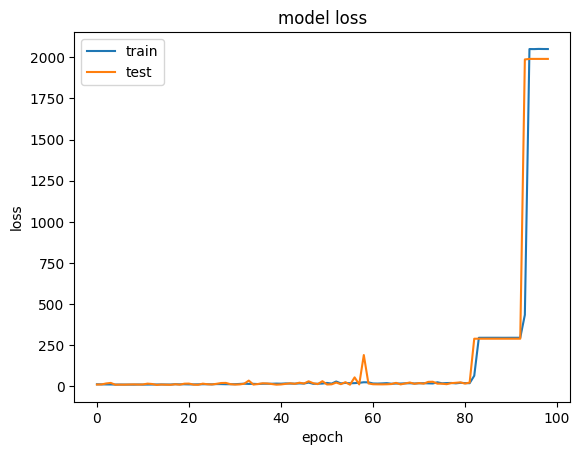

In [16]:

import matplotlib.pyplot as plt
import numpy as np

plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
X_train / 255